# Protein Background
Zoë Steier

2/8/20

* Explore anecdotal cases of protein background
* Compare totalVI with a GMM cutoff 
* Dataset: spleen and lymph node with 111 protein panel from experiment day 1.

## Imports and settings

In [1]:
# Import required packages

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc 
import anndata
import seaborn as sns
from scipy import stats
import torch

from scvi.dataset import CellMeasurement, AnnDatasetFromAnnData, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer
from scvi import set_seed

%load_ext autoreload
%autoreload 2
%matplotlib inline

set_seed(0)

In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

In [3]:
# GPU settings

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

## Load data

In [4]:
# Load anndata
save_path = "/data/yosef2/users/adamgayoso/projects/totalVI_journal/data/"

anndataset = anndata.read(save_path + "spleen_lymph_111.h5ad")
anndataset = anndataset[anndataset.obs["batch_indices"] == 0]

In [5]:
# Filter unwanted proteins (isotype controls and HTO)
keep_pro_111 = np.array(
    [not p.startswith("HTO") for p in anndataset.uns["protein_names"]]
)

anndataset.obsm["protein_expression"] = anndataset.obsm["protein_expression"][
    :, keep_pro_111
]
anndataset.uns["protein_names"] = anndataset.uns["protein_names"][keep_pro_111]

# Organize and instantiate scVI dataset
hvg_111 = anndataset.var["hvg_encode"]

dataset = AnnDatasetFromAnnData(ad=anndataset[:, hvg_111])
protein_data_111 = CellMeasurement(
    name="protein_expression",
    data=anndataset.obsm["protein_expression"].astype(np.float32),
    columns_attr_name="protein_names",
    columns=anndataset.uns["protein_names"]
)
dataset.initialize_cell_measurement(protein_data_111)
dataset.gene_names = anndataset[:, hvg_111].var_names.values

[2020-03-02 21:28:36,680] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-03-02 21:28:36,684] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-03-02 21:28:36,747] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-03-02 21:28:36,811] INFO - scvi.dataset.dataset | Downsampled from 9264 to 9264 cells


In [6]:
dataset

GeneExpressionDataset object with n_cells x nb_genes = 9264 x 4005
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'protein_expression', 'labels', 'local_vars', 'batch_indices', 'local_means'
    cell_categorical_attribute_names: 'labels', 'batch_indices'
    cell_measurements_columns: {'protein_expression': 'protein_names'}

## Load and evaluate totalVI model

In [7]:
model = TOTALVI(
    dataset.nb_genes,
    dataset.protein_expression.shape[1],
    n_latent=20,
    #n_batch=dataset.n_batches,
)

In [8]:
use_cuda = True
lr = 4e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 45,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 30,
    "lr_factor": 0.6,
    "posterior_class": TotalPosterior,
}

In [9]:
model.load_state_dict(torch.load("/data/yosef2/users/zsteier/totalVI/totalVI_journal/differential_expression/saved_models/111_d1.pt"))
model.eval()

TOTALVI(
  (encoder): EncoderTOTALVI(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=4115, out_features=256, bias=True)
          (1): BatchNorm1d(256, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (z_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (z_mean_encoder): Linear(in_features=256, out_features=20, bias=True)
    (z_var_encoder): Linear(in_features=256, out_features=20, bias=True)
    (l_gene_encoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [10]:
trainer = TotalTrainer(
    model,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    data_loader_kwargs={"batch_size": 256, "pin_memory": False}
)

## Generate and save model outputs

In [11]:
# create posterior on full data
full_posterior = trainer.create_posterior(
    model, dataset, indices=np.arange(len(dataset)), type_class=TotalPosterior
)

In [12]:
# extract latent space
latent_mean, batch_index, label, library_gene = full_posterior.sequential().get_latent()

In [13]:
# calculate protein background probabilities

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Number of Monte Carlo samples to average over
n_samples = 25 # set to 2 to run faster
# Probability of background on logits scale, first dataset.nb_genes columns corresponds to ZI probability for genes
# py_mixing was previously px_dropout

# take mean of sigmoid, not sigmoid of the mean
py_mixing = np.mean(sigmoid(
    full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=False)
), axis=-1)
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=dataset.protein_names
)

In [14]:
# denoised has shape n_cells by (n_input_genes + n_input_proteins) with protein features concatenated to the genes
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True,
) # tranform batch puts all denoised samples into the same batch, here, choose WT
# input a list to average over all batches if give_mean = True

In [212]:
anndataset

AnnData object with n_obs × n_vars = 9264 × 13553 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'
    uns: 'protein_names', 'version'
    obsm: 'protein_expression'

In [305]:
# Create a posterior adata object
post_adata = anndataset[:, hvg_111].copy() # subset to totalVI genes
post_adata.obsm["X_totalVI"] = latent_mean # add latent mean

# Add denoised counts to anndata
post_adata.obsm["denoised_proteins"] = denoised_proteins
post_adata.obsm["denoised_genes"] = denoised_genes

# Add metadata
post_adata.obs["batch_indices"] = dataset.batch_indices.astype(str)

# Add raw protein counts
post_adata.uns["protein_names"] = dataset.protein_names
post_adata.obsm["protein_expression"] = dataset.protein_expression

## Add to anndata scvi gene and protein names
post_adata.uns["totalVI_genes"] = dataset.gene_names
post_adata.uns["totalVI_proteins"] = dataset.protein_names

In [306]:
post_adata

AnnData object with n_obs × n_vars = 9264 × 4005 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types'
    var: 'gene_ids', 'feature_types', 'highly_variable', 'highly_variable_mean_variance', 'encode', 'hvg_encode'
    uns: 'protein_names', 'version', 'totalVI_genes', 'totalVI_proteins'
    obsm: 'protein_expression', 'X_totalVI', 'denoised_proteins', 'denoised_genes'

In [308]:
# Run UMAP
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=15, metric="correlation") # use latent mean for similarity metric
sc.tl.umap(post_adata, min_dist=0.5)

/data/yosef2/users/zsteier/programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../programs/miniconda/envs/scvi_041/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


... storing 'batch_indices' as categorical


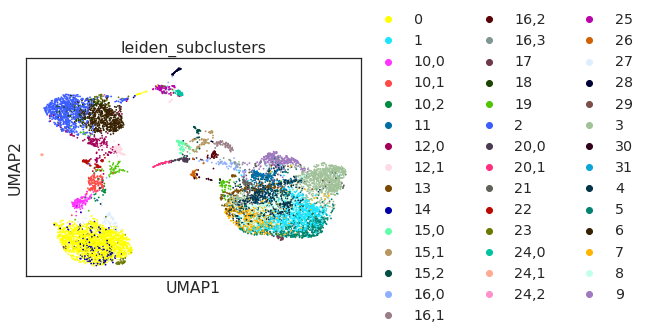

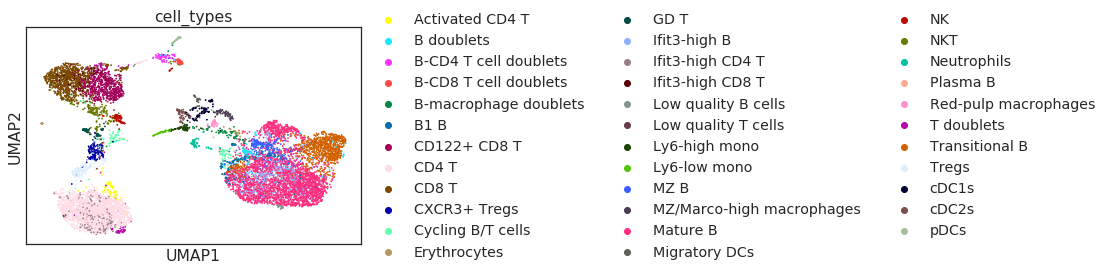

In [309]:
sc.pl.umap(
    post_adata, 
    color=["leiden_subclusters"], # This was generated on all of the data
    ncols=1
)

sc.pl.umap(
    post_adata, 
    color=["cell_types"], # This was generated on all of the data
    ncols=1
)

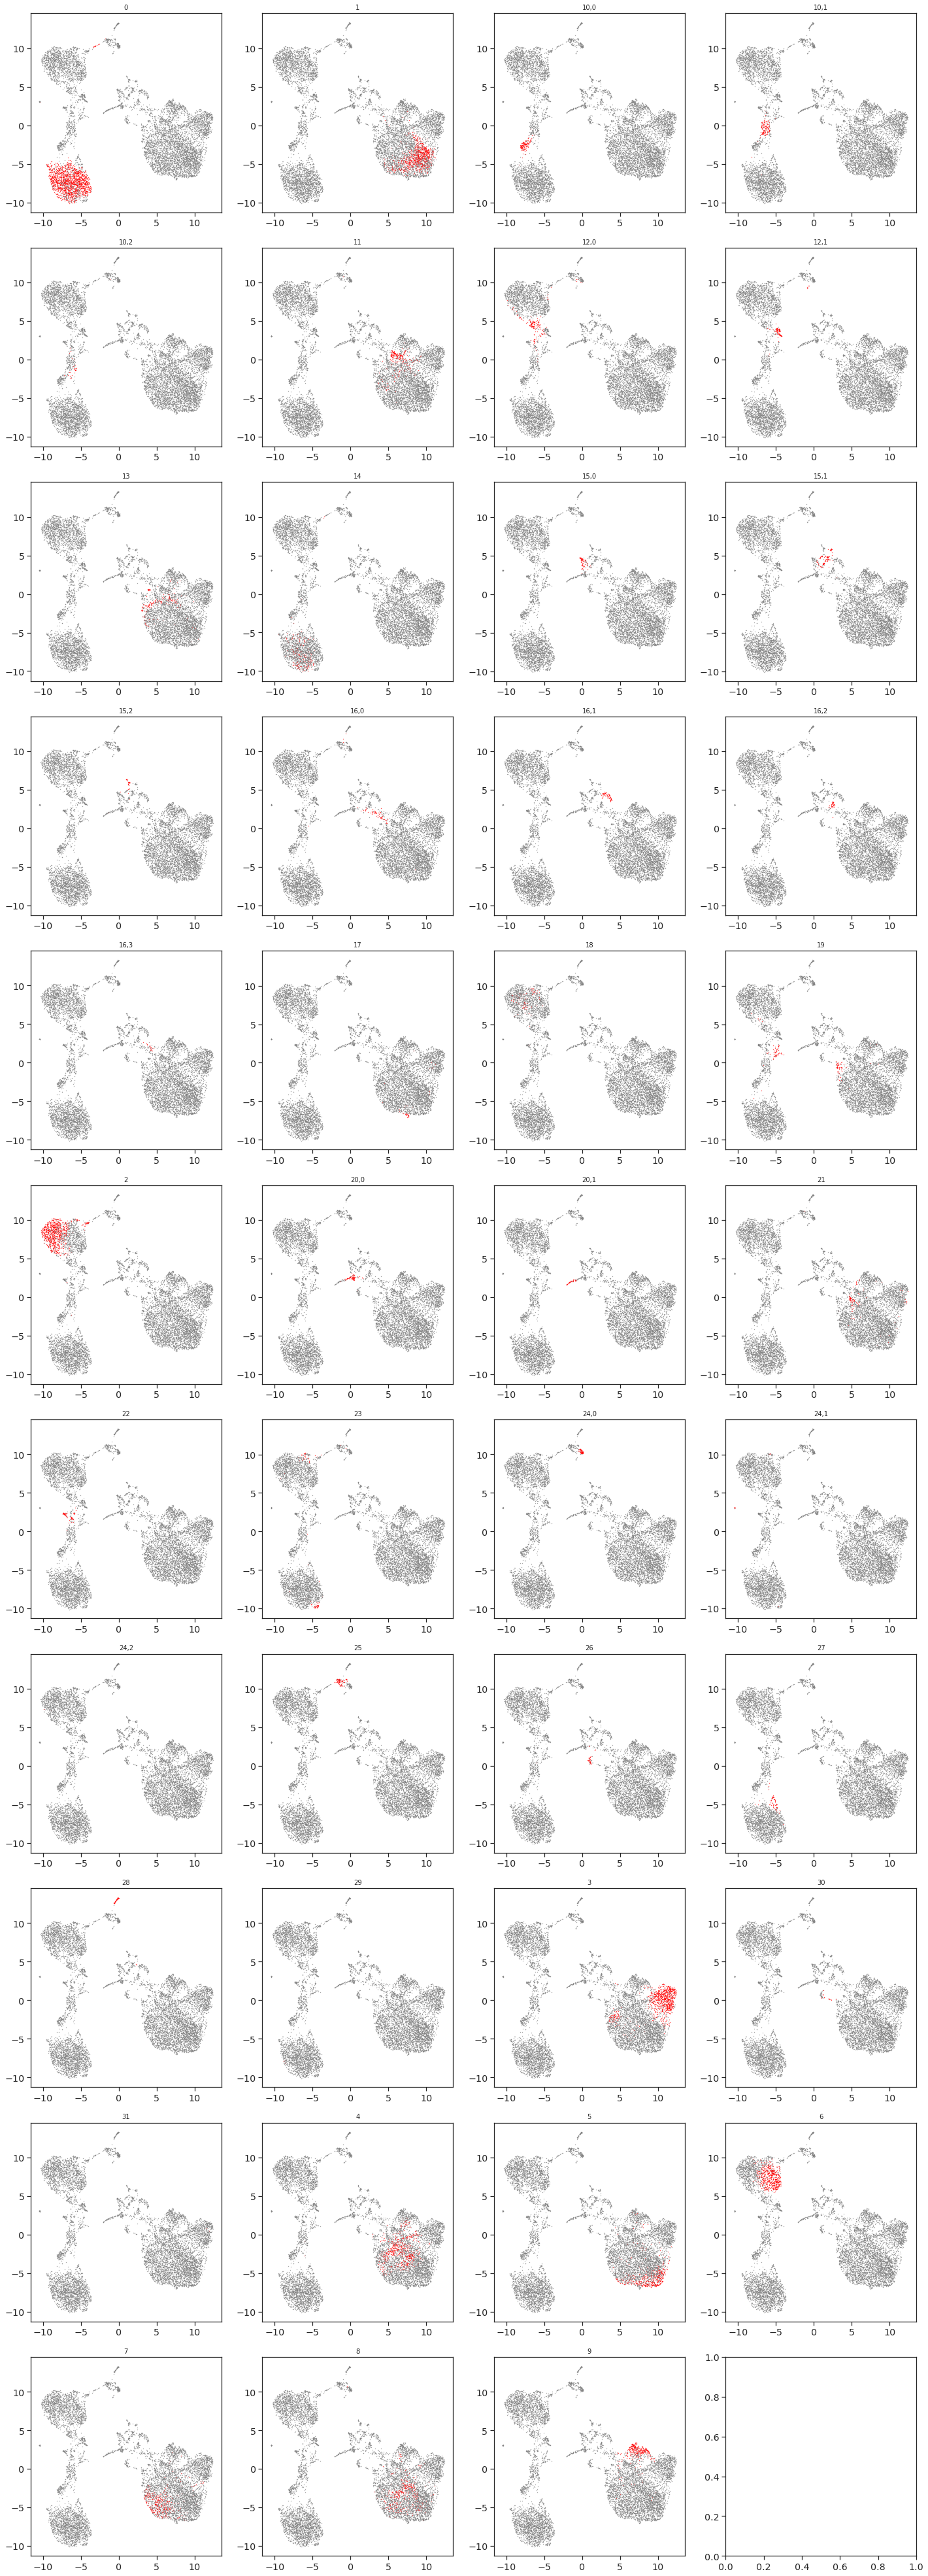

In [310]:
# Plot each cluster independently

fig, ax = plt.subplots(11, 4, figsize=(20, 55))
clusters = np.array((post_adata.obs["leiden_subclusters"])).ravel()
for c in range(len(np.unique(clusters))):
    ax.flat[c].scatter(x = post_adata.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 0], y = post_adata.obsm["X_umap"][clusters==np.unique(clusters)[c]][:, 1], s=.1,
                      c = "red")
    ax.flat[c].scatter(x = post_adata.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 0], y = post_adata.obsm["X_umap"][clusters!=np.unique(clusters)[c]][:, 1], s=.1,
                      c = "grey")
    ax.flat[c].set_title(str(np.unique(clusters)[c]), fontsize = 10)

plt.tight_layout()

In [311]:
# Add denoised protein counts and foreground probabilities for plotting
for i, p in enumerate(dataset.protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{}".format(p)] = denoised_proteins[:, i] # each protein's count is its denoised value

In [312]:
post_adata

AnnData object with n_obs × n_vars = 9264 × 4005 
    obs: 'n_protein_counts', 'n_proteins', 'seurat_hash_id', 'batch_indices', 'hash_id', 'n_genes', 'percent_mito', 'leiden_subclusters', 'cell_types', 'ADT_CD102_A0104_fore_prob', 'ADT_CD102_A0104', 'ADT_CD103_A0201_fore_prob', 'ADT_CD103_A0201', 'ADT_CD106_A0226_fore_prob', 'ADT_CD106_A0226', 'ADT_CD115(CSF-1R)_A0105_fore_prob', 'ADT_CD115(CSF-1R)_A0105', 'ADT_CD117(c-Kit)_A0012_fore_prob', 'ADT_CD117(c-Kit)_A0012', 'ADT_CD11a_A0595_fore_prob', 'ADT_CD11a_A0595', 'ADT_CD11c_A0106_fore_prob', 'ADT_CD11c_A0106', 'ADT_CD122(IL-2Rb)_A0227_fore_prob', 'ADT_CD122(IL-2Rb)_A0227', 'ADT_CD127(IL-7Ra)_A0198_fore_prob', 'ADT_CD127(IL-7Ra)_A0198', 'ADT_CD134(OX-40)_A0195_fore_prob', 'ADT_CD134(OX-40)_A0195', 'ADT_CD135_A0098_fore_prob', 'ADT_CD135_A0098', 'ADT_CD137_A0194_fore_prob', 'ADT_CD137_A0194', 'ADT_CD14_A0424_fore_prob', 'ADT_CD14_A0424', 'ADT_CD140a_A0573_fore_prob', 'ADT_CD140a_A0573', 'ADT_CD15(SSEA-1)_A0076_fore_prob', 'ADT_CD15(SSEA

In [316]:
# Save anndata
post_adata.write("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_111day1.h5ad", compression="gzip")

In [317]:
# Read the previously saved anndata object (only need to run the above section once)
adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_111day1.h5ad")

## Run GMM as baseline for totalVI comparison

In [319]:
# Run GMM on all proteins and all cells

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
log_protein = np.log1p(adata.obsm["protein_expression"])
post_probs = []
gmm_classifier = []
for col in range(log_protein.shape[1]):
    gmm = GaussianMixture(n_components=2)
    probs = gmm.fit(log_protein[:, col].reshape(-1, 1)).predict_proba(log_protein[:, col].reshape(-1, 1))
    
    # Make sure lower mode is first mean
    means = gmm.means_.ravel()
    mean_order = np.argsort(means)
    #print(means[mean_order])
    probs = probs[:, mean_order]
    # Only need the probability of being "on"
    post_probs.append(probs[:, 1])
    labels = np.argmax(probs, axis=1).flatten()
    gmm_classifier.append(labels)
gmm_classifier = np.array(gmm_classifier).T # the prediction
post_probs = np.array(post_probs).T # equivalent of probability foreground in totalVI


## Run standard scanpy normalization of RNA for plotting of raw data

In [321]:
# Normalize for library size (adjust to 10,000 counts/cell)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Log the data
sc.pp.log1p(adata)

# Save log(raw) as adata.raw
adata.raw = adata

## Plot anecdotes

In [324]:
# Find matched RNA-protein names
encoded_proteins = pd.Series(adata.var["encode"][adata.var["encode"] != "None"], name = "Protein")

In [325]:
# Collect data for plotting: protein foreground and log(raw protein counts)
foreground = pd.DataFrame(np.array(adata.obs.filter(regex='fore_prob')), columns = adata.uns["totalVI_proteins"]) 
log_protein = np.log1p(adata.obsm["protein_expression"])

In [328]:
# For a given RNA, plot protein expression vs protein foreground, positive/negative cells on UMAP, RNA expression, and RNA/protein raw/denoised expression levels on UMAP.

def background_anecdote(RNA_name, save_figs):
    ### RNA_name is name (all caps) of RNA
    
    fig_path = "/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/"
    
    # Collect data to plot
    protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]
    protein_fore = foreground[protein_name]
    rna_raw = pd.Series(adata.raw.X[:, adata.var.index == RNA_name].ravel())
    protein_raw = pd.Series(log_protein[:, adata.uns["totalVI_proteins"] == protein_name].ravel())
    rna_denoised = pd.Series(adata.obsm["denoised_genes"][:, adata.uns["totalVI_genes"] == RNA_name].ravel())
    protein_denoised = pd.Series(adata.obsm["denoised_proteins"][:, adata.uns["totalVI_proteins"] == protein_name].ravel())
    
    # Add to adata for plotting
    adata.obs[protein_name + "_raw"] = protein_raw.values
    adata.obs[RNA_name + "_denoised"] = rna_denoised.values
    
    # Find the thresholds for the anecdotal cases according to the GMM
    # The expression value at which 50% probability in mode 1, 50% in mode 2 (or closest to 50%)
    protein_idx = np.where(adata.uns["totalVI_proteins"] == protein_name)[0][0]
    cutoff_idx = (np.abs(post_probs[:, protein_idx] - 0.5)).argmin()
    gmm_cutoff = protein_raw[cutoff_idx] # Raw value that serves as the cutoff

    # Select cells to highlight
    #gmm_cutoff is the raw protein threshold
    pr_fore_highthresh = 0.8
    pr_fore_lowthresh = 0.2
    q1 = np.logical_and(protein_fore > pr_fore_highthresh, protein_raw > gmm_cutoff)
    q2 = np.logical_and(protein_fore > pr_fore_highthresh, protein_raw < gmm_cutoff)
    q3 = np.logical_and(protein_fore < pr_fore_lowthresh, protein_raw < gmm_cutoff)
    q4 = np.logical_and(protein_fore < pr_fore_lowthresh, protein_raw > gmm_cutoff)
#     uncertain_high = np.logical_and(protein_fore > 0.5, protein_fore < 0.8)
#     uncertain_low = np.logical_and(protein_fore < 0.5, protein_fore > 0.2)

    categories = [q1, q2, q3, q4]
    
    # Plot protein raw colored by quadrant
    fig = sns.jointplot(x = protein_raw, y = protein_fore, kind = "scatter", s = 1, color = ".4", rasterized = True, # scatter
                       marginal_kws = dict(bins = 50),
                       )
    fig.set_axis_labels("log(protein counts + 1)", "totalVI probability(foreground)")

    fig.ax_joint.scatter(x = protein_raw[q1], y = protein_fore[q1], s = 1, c = colors[1], rasterized = True)
    fig.ax_joint.scatter(x = protein_raw[q2], y = protein_fore[q2], s = 1, c = colors[0], rasterized = True)
    fig.ax_joint.scatter(x = protein_raw[q3], y = protein_fore[q3], s = 1, c = colors[3], rasterized = True)
    fig.ax_joint.scatter(x = protein_raw[q4], y = protein_fore[q4], s = 1, c = colors[2], rasterized = True)
    fig.ax_joint.axvline(x = gmm_cutoff, linestyle="--", c="black")
    fig.ax_marg_x.axvline(x = gmm_cutoff, linestyle="--", c="black")
    fig.ax_joint.set_ylim(0,1)
    fig.ax_joint.axhline(y = pr_fore_highthresh, linestyle="--", c="black")
    fig.ax_joint.axhline(y = pr_fore_lowthresh, linestyle="--", c="black")
    if save_figs == True:
        fig.savefig(fig_path + "%s_scatter_prforeground.pdf" % RNA_name, dpi = DPI)


    # Plot UMAP to highlight cells

    greycolor = "0.92"
    fig, ax = plt.subplots(2, 2, figsize=(5, 5)) # 1, 4, (16, 4)
    ptsize = .2
   
    ax.flat[0].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)
    ax.flat[1].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)
    ax.flat[2].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)
    ax.flat[3].scatter(x = adata.obsm["X_umap"][:,0], y = adata.obsm["X_umap"][:,1], s = ptsize, c = greycolor, rasterized = True)

    ax.flat[1].scatter(x = adata.obsm["X_umap"][q1,0], y = adata.obsm["X_umap"][q1,1], s = ptsize, c = colors[1], rasterized = True)
    ax.flat[0].scatter(x = adata.obsm["X_umap"][q2,0], y = adata.obsm["X_umap"][q2,1], s = ptsize, c = colors[0], rasterized = True)
    ax.flat[2].scatter(x = adata.obsm["X_umap"][q3,0], y = adata.obsm["X_umap"][q3,1], s = ptsize, c = colors[3], rasterized = True)
    ax.flat[3].scatter(x = adata.obsm["X_umap"][q4,0], y = adata.obsm["X_umap"][q4,1], s = ptsize, c = colors[2], rasterized = True)
    
    ax.flat[0].set_xticklabels([])
    ax.flat[0].set_yticklabels([])
    ax.flat[0].tick_params(axis='both', which='both', length=0)
    ax.flat[1].set_xticklabels([])
    ax.flat[1].set_yticklabels([])
    ax.flat[1].tick_params(axis='both', which='both', length=0)
    ax.flat[2].set_xticklabels([])
    ax.flat[2].set_yticklabels([])
    ax.flat[2].tick_params(axis='both', which='both', length=0)
    ax.flat[3].set_xticklabels([])
    ax.flat[3].set_yticklabels([])
    ax.flat[3].tick_params(axis='both', which='both', length=0)
    sns.despine()

    plt.tight_layout()
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_highlightCells.pdf" % RNA_name, dpi = DPI)


    # Plot RNA histogram
    fig, ax = plt.subplots(2, 2, figsize=(5, 5), sharex = True) # sharex is needed for the x axis to match (4,1)

    ax.flat[1].hist(x = rna_raw[q1], density = True, color = colors[1])#, bins = 15)
    ax.flat[0].hist(x = rna_raw[q2], density = True, color = colors[0])#, bins = 15)
    ax.flat[2].hist(x = rna_raw[q3], density = True, color = colors[3])#, bins = 15)
    ax.flat[3].hist(x = rna_raw[q4], density = True, color = colors[2])#, bins = 15)
    sns.despine()
    plt.tight_layout()
    if save_figs == True:
        fig.savefig(fig_path + "%s_RNA_histogram.pdf" % RNA_name, dpi = DPI)

    
# Plot UMAPs colored by raw or denoised expression    
    # Plot RNA raw
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        #use_raw = False,
        color=[RNA_name], # , "ADT_CD20_A0192"
        title = [RNA_name + " RNA (log raw)"], # , "CD20 protein (denoised)"
        ncols=1, 
        #color_map = "viridis",
        frameon = False,
        ax = ax,
        #return_fig = True
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_RNA_raw.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')


    # Plot protein raw
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        #use_raw = False,
        color=[protein_name + "_raw"], # , 
        title = [protein_name + " (log raw)"], # 
        ncols=1, 
        #color_map = "viridis",
        frameon = False,
        ax = ax,
        #return_fig = True
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_protein_raw.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

    
    # Plot RNA denoised
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        #use_raw = False,
        color=[RNA_name + "_denoised"], # , "ADT_CD20_A0192"
        title = [RNA_name + " RNA (denoised)"], # , "CD20 protein (denoised)"
        ncols=1, 
        #color_map = "viridis",
        frameon = False,
        ax = ax,
        #return_fig = True
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_RNA_denoised.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

    # Plot protein denoised
    fig, ax = plt.subplots(figsize=(4, 4))
    sc.pl.umap(
        adata, 
        color=[protein_name], # , 
        title = [protein_name + " (denoised)"], # , 
        ncols=1, 
        #color_map = "viridis",
        frameon = False,
        ax = ax,
        #return_fig = True
    )
    ax.set_aspect("equal")
    if save_figs == True:
        fig.savefig(fig_path + "%s_umap_protein_denoised.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

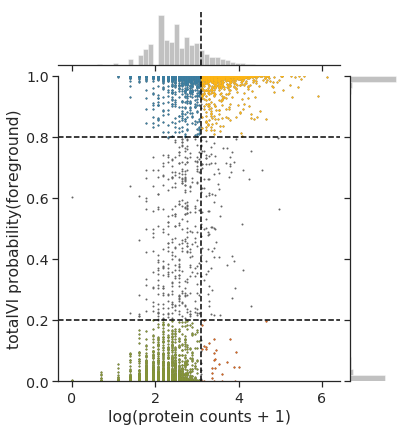

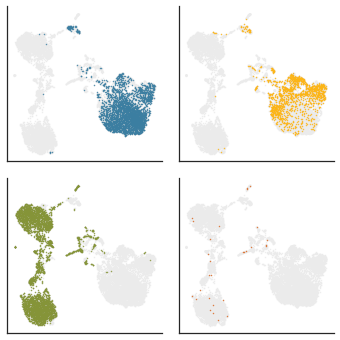

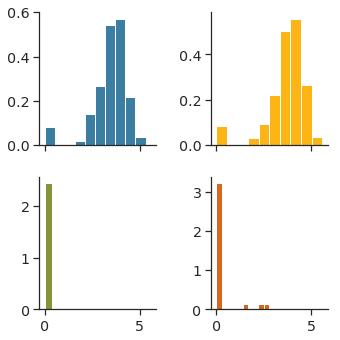

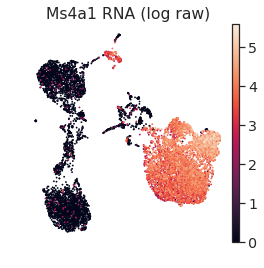

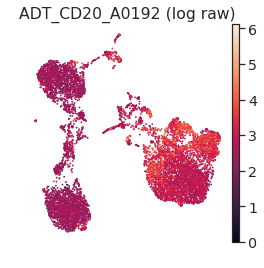

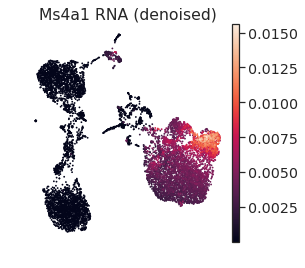

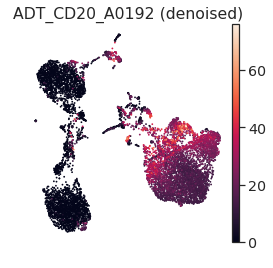

In [205]:
# Hard case
background_anecdote("Ms4a1", save_figs = True)

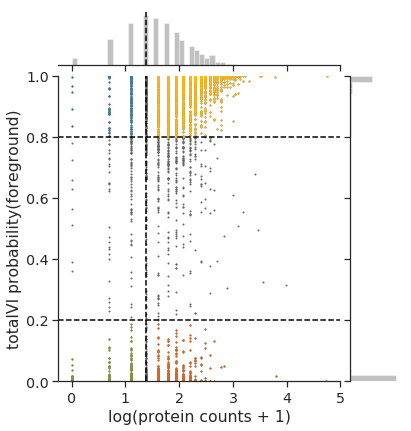

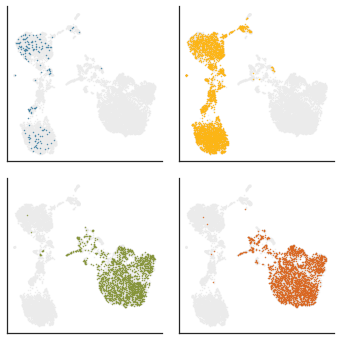

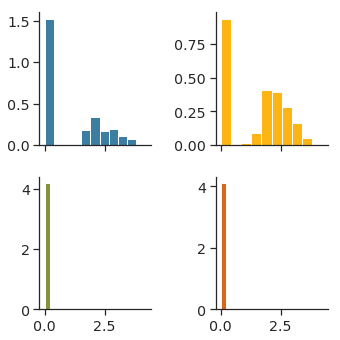

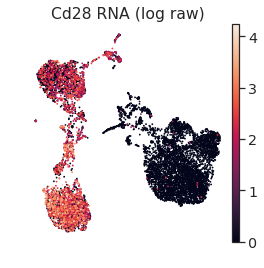

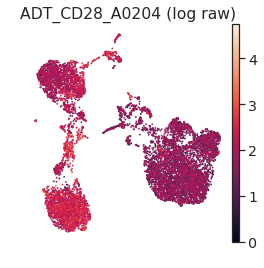

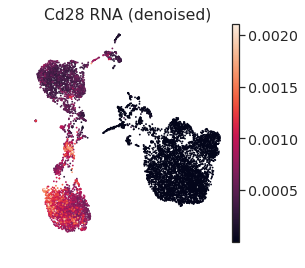

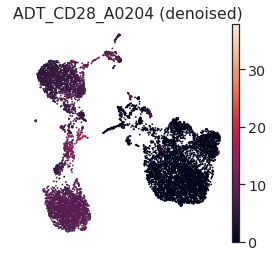

In [206]:
# Hard case
background_anecdote("Cd28", save_figs = True)

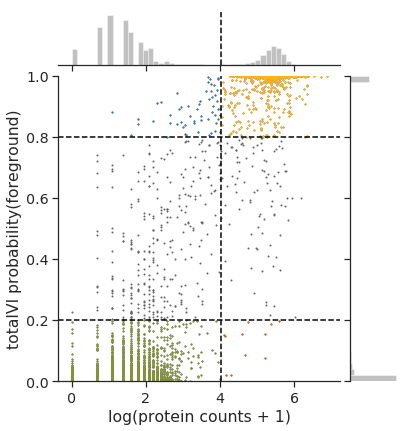

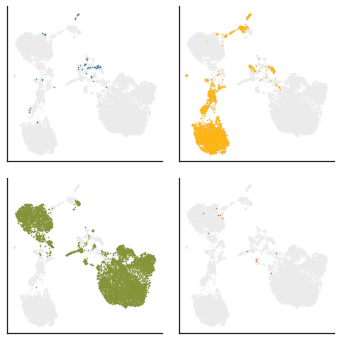

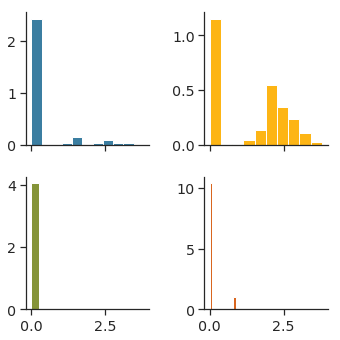

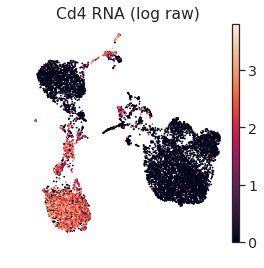

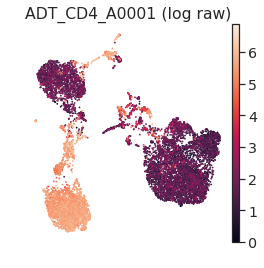

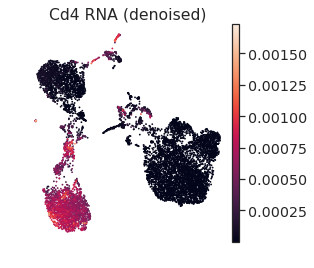

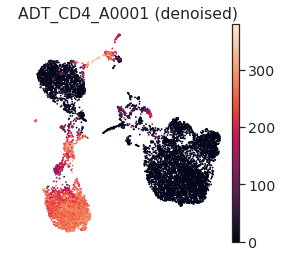

In [207]:
# Easy case
background_anecdote("Cd4", save_figs = True)

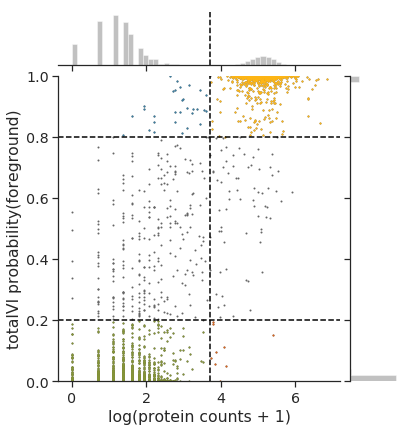

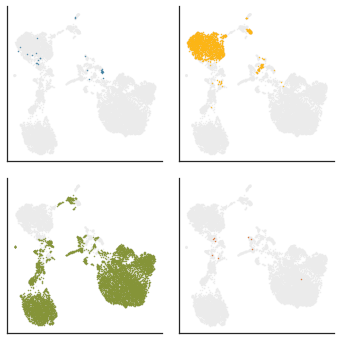

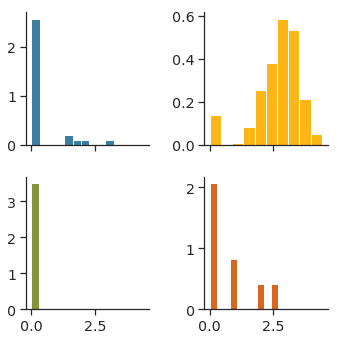

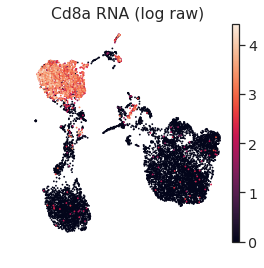

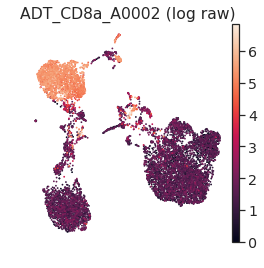

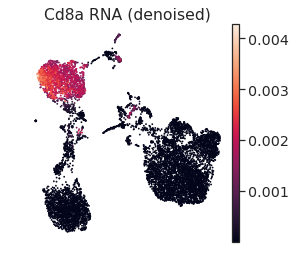

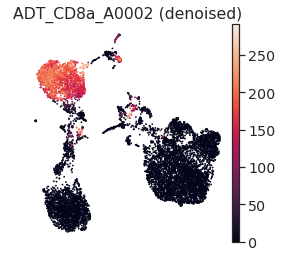

In [208]:
# Easy case
background_anecdote("Cd8a", save_figs = True)

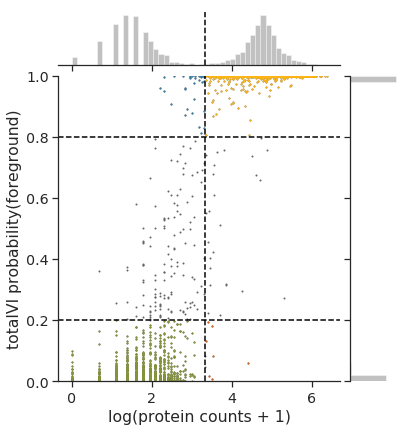

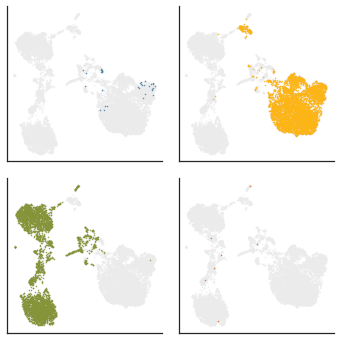

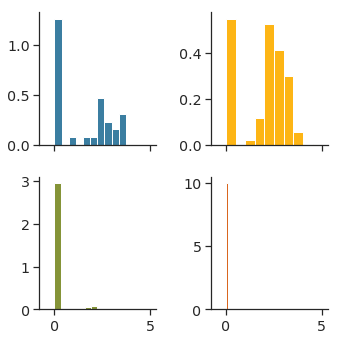

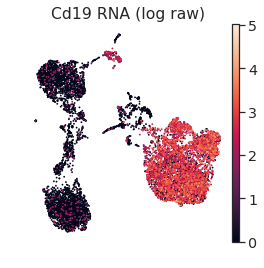

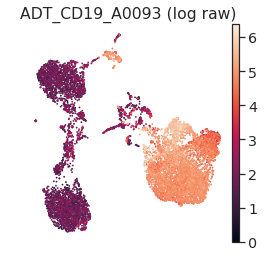

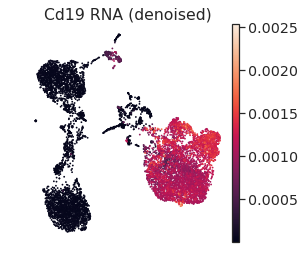

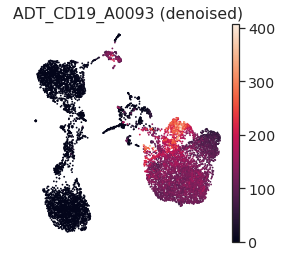

In [209]:
# Easy case
background_anecdote("Cd19", save_figs = True)

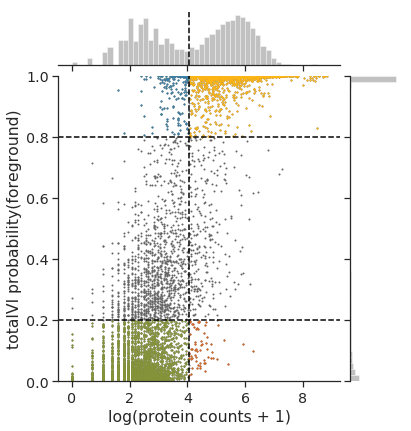

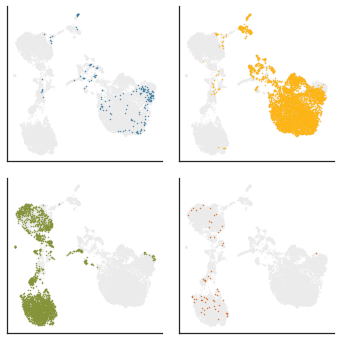

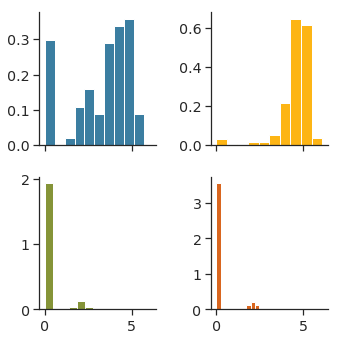

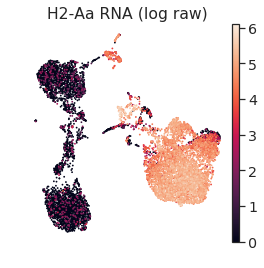

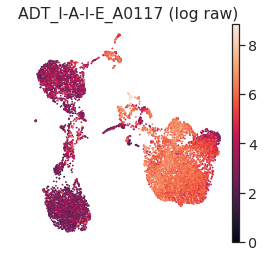

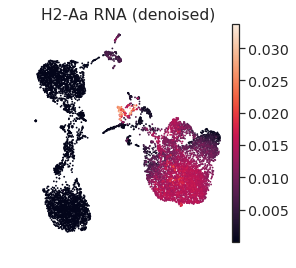

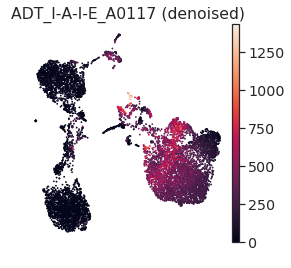

In [210]:
# Moderate case
background_anecdote("H2-Aa", save_figs = True)

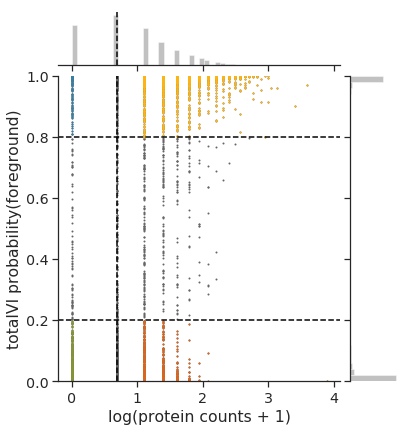

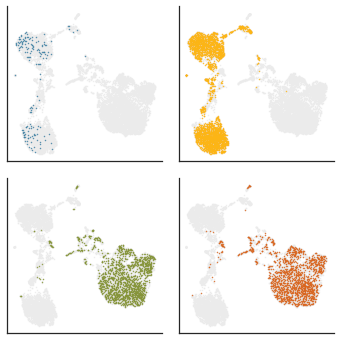

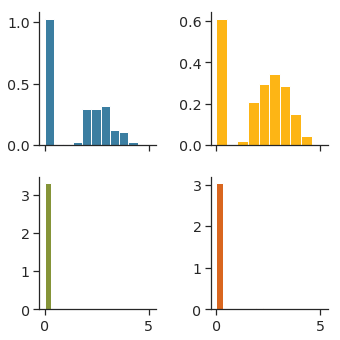

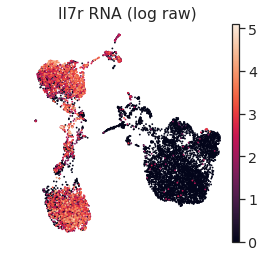

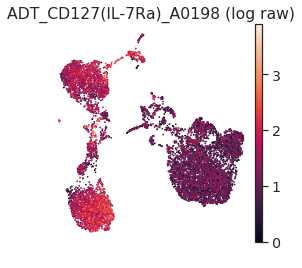

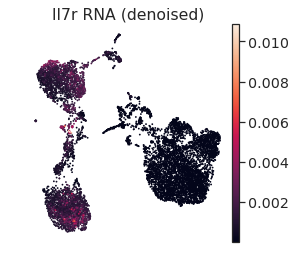

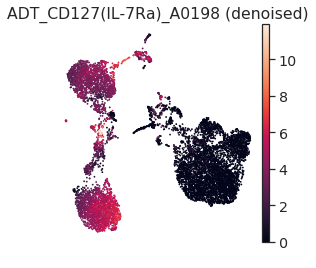

In [211]:
# Moderate case
background_anecdote("Il7r", save_figs = True)

## Plot examples of denoising protein counts

In [123]:
import matplotlib

In [60]:
# Get denoised samples

# Generate denoised samples
denoised_data = full_posterior.generate_denoised_samples(
    n_samples=2,
    #batch_size=batch_size,
    #rna_size_factor=rna_size_factor,
    #transform_batch=b,
)



In [61]:
# Concatenate the denoised data

flattened = np.zeros(
    (denoised_data.shape[0] * denoised_data.shape[2], denoised_data.shape[1])
)
for i in range(denoised_data.shape[2]):
    flattened[
        denoised_data.shape[0] * (i) : denoised_data.shape[0] * (i + 1)
    ] = denoised_data[:, :, i]

In [62]:
flattened.shape # two samples for every cell

(18528, 4115)

In [67]:
# only use the first sample
flattened_sample1 = flattened[0:dataset.X.shape[0],:]

In [68]:
flattened_sample1.shape

(9264, 4115)

In [73]:
gene_protein_names = np.concatenate((dataset.gene_names, dataset.protein_names))
len(gene_protein_names

4115

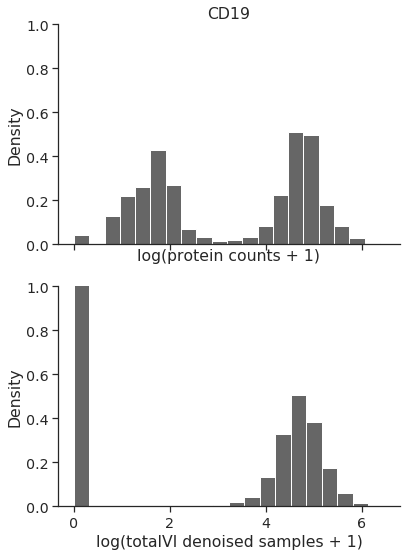

In [384]:
# Plot raw and denoised counts
# For presentation

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharey = True, sharex = True)
RNA_name = "Cd19"
num_bins = 20
protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]]), bins = num_bins,
          density = True, color = ".4" # colors[3]
          )
ax[0].set(ylabel = "Density")
ax[0].set(xlabel = "log(protein counts + 1)")
protein_title = protein.split("_")[1].split("(")[0]
ax[0].set_title(protein_title)
ax[0].set_ylim(0, 1)

ax[1].hist(np.log1p(flattened_sample1[:, np.where(gene_protein_names == protein)[0][0]]), bins = num_bins,
          density = True, color = ".4" # colors[3]
          )
ax[1].set(xlabel = "log(totalVI denoised samples + 1)")
ax[1].set(ylabel = "Density")
ax[1].set_ylim(0, 1)


sns.despine()
plt.tight_layout()

#fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/Denoised_%s_histogram.pdf" % protein_title, dpi=DPI, bbox_inches='tight')

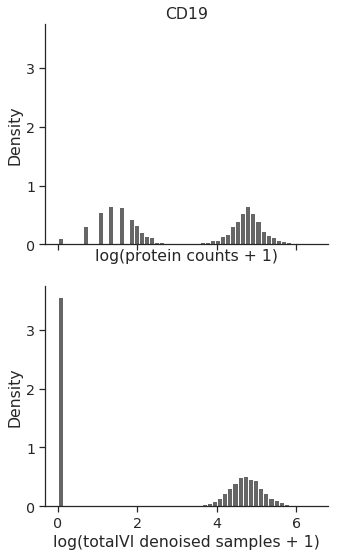

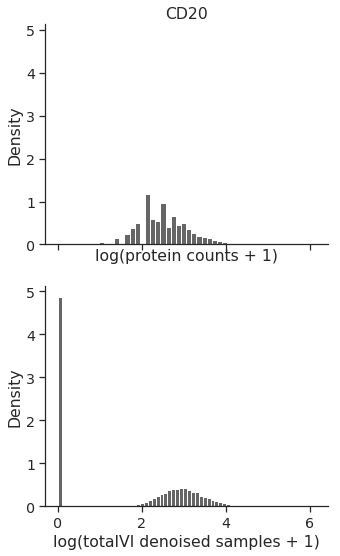

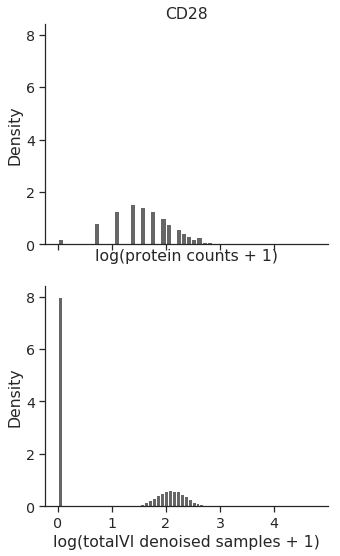

In [386]:
# For journal
# Plot raw and denoised counts
# For presentation
for RNA_name in ["Cd19", "Ms4a1", "Cd28"]:
    fig, ax = plt.subplots(2, 1, figsize=(5, 8), sharey = True, sharex = True)
    #RNA_name = "Cd19"
    num_bins = 50
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

    ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]]), bins = num_bins,
              density = True, color = ".4" # colors[3]
              )
    ax[0].set(ylabel = "Density")
    ax[0].set(xlabel = "log(protein counts + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[0].set_title(protein_title)
    #ax[0].set_ylim(0, 1)

    ax[1].hist(np.log1p(flattened_sample1[:, np.where(gene_protein_names == protein)[0][0]]), bins = num_bins,
              density = True, color = ".4" # colors[3]
              )
    ax[1].set(xlabel = "log(totalVI denoised samples + 1)")
    ax[1].set(ylabel = "Density")
    #ax[1].set_ylim(0, 1)


    sns.despine()
    plt.tight_layout()

    fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/Denoised_%s_histogram.pdf" % protein_title, dpi=DPI, bbox_inches='tight')

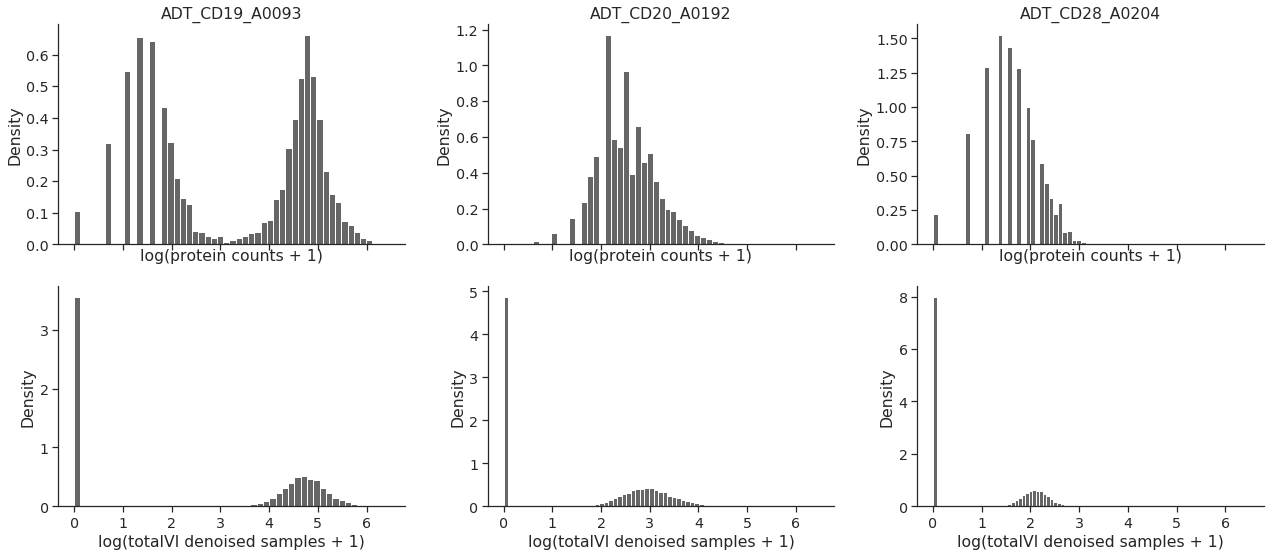

In [366]:
fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex = True,
                       #sharey = True, 
                      )
num_bins = 50

for i, RNA_name in enumerate(["Cd19", "Ms4a1", "Cd28"]):
    #RNA_name = "Cd19"
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

    ax.flat[i].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]]), 
               bins = num_bins,
              density = True, color = ".4" # colors[3]
              )
    ax.flat[i].set(ylabel = "Density")
    ax.flat[i].set(xlabel = "log(protein counts + 1)")
    ax.flat[i].set_title(protein)
    #ax[0].set_ylim(0, 1)

    ax.flat[i + 3].hist(np.log1p(flattened_sample1[:, np.where(gene_protein_names == protein)[0][0]]), 
               bins = num_bins,
              density = True, color = ".4" # colors[3]
              )
    ax.flat[i + 3].set(xlabel = "log(totalVI denoised samples + 1)")
    ax.flat[i + 3].set(ylabel = "Density")
#ax[1].set_ylim(0, 1)


sns.despine()
plt.tight_layout()

## ROC curves of totalVI vs GMM classifyier

In [256]:
import sklearn

In [258]:
# Cells to test: B cells, CD4 T cells
# True/False for each cell
# tcells = adata.obs["leiden_totalVI_0.8"].isin(["0", "10", "2", "8"])
# cd4tcells = adata.obs["leiden_totalVI_0.8"].isin(["0", "10"])
# cd8tcells = adata.obs["leiden_totalVI_0.8"].isin(["2", "8"])
# treg = adata.obs["leiden_totalVI_0.8"].isin(["10"])
# bcells = adata.obs["leiden_totalVI_0.8"].isin(["1", "3", "4", "5", "7", "11", "12", "13"])


# # B cells
bcells = np.array([
    c in ["1", "3", "4", "5", "7", "8", "9", "11", "13"]
    for c in adata.obs["leiden_subclusters"]
])

# CD4 T cells
cd4tcells = np.array([
    c in ["0", "14", "27", "10,0", "10,1"]
    for c in adata.obs["leiden_subclusters"]
])

# Treg
treg = np.array([
    c in ["10,0", "10,1"]
    for c in adata.obs["leiden_subclusters"]
])

# All T cells
tcells = np.array([
    c in ["0", "14", "27", "10,0", "10,1", # CD4
         "2", "6", "18"] # CD8
    for c in adata.obs["leiden_subclusters"]
])

# CD8 T cells
cd8tcells = np.array([
    c in ["2", "6", "18"] # CD8
    for c in adata.obs["leiden_subclusters"]
])

In [259]:
# Sets of cells
all_bt = tcells | bcells
all_cells = np.full(len(adata.obs.index), True) # make new array with all True

In [260]:
# GMM foreground dataframe with protein names for all cells, all proteins
gmm_fore = pd.DataFrame(post_probs, columns = adata.uns["protein_names"])

### Plot and save three example ROC curves

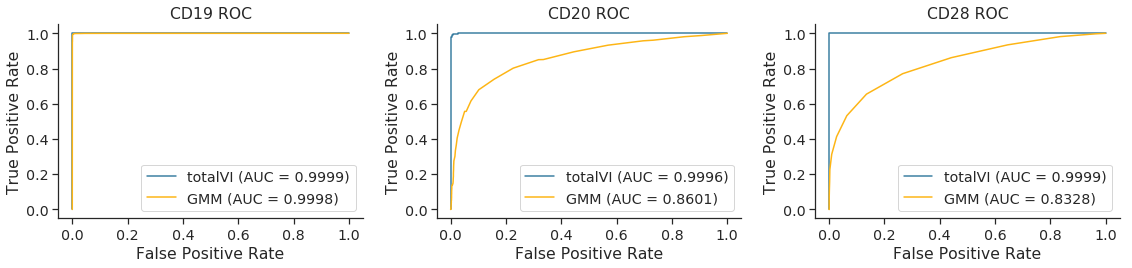

In [410]:
# Plot ROC curves
fig, ax = plt.subplots(1, 3, figsize=(16, 4)) # fig, ax = plt.subplots(2, 2, figsize=(10, 8)) # 

cells = all_bt

###### First plot: CD19
RNA_name = "Cd19"
protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

# Calculate ROC AUC
totalvi_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = foreground[protein_name][cells])
gmm_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = foreground[protein_name][cells])
ax.flat[0].plot(fpr, tpr, label = "totalVI (AUC = {0:0.4f})" "".format(totalvi_auc))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])
ax.flat[0].plot(fpr, tpr, label = "GMM (AUC = {0:0.4f})" "".format(gmm_auc))

ax.flat[0].set_xlabel("False Positive Rate")
ax.flat[0].set_ylabel("True Positive Rate")
protein_title = protein_name.split("_")[1].split("(")[0]

ax.flat[0].set_title(protein_title + " ROC")
ax.flat[0].legend()

# turn off axes for empty spot
#ax.flat[1].axis('off')

###### Second plot: CD20
RNA_name = "Ms4a1"
protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

# Calculate ROC AUC
totalvi_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = foreground[protein_name][cells])
gmm_auc = sklearn.metrics.roc_auc_score(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = foreground[protein_name][cells])
ax.flat[1].plot(fpr, tpr, label = "totalVI (AUC = {0:0.4f})" "".format(totalvi_auc))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = bcells[cells], y_score = gmm_fore[protein_name][cells])
ax.flat[1].plot(fpr, tpr, label = "GMM (AUC = {0:0.4f})" "".format(gmm_auc))

ax.flat[1].set_xlabel("False Positive Rate")
ax.flat[1].set_ylabel("True Positive Rate")
protein_title = protein_name.split("_")[1].split("(")[0]

ax.flat[1].set_title(protein_title + " ROC")
ax.flat[1].legend()


###### Third plot: CD28
RNA_name = "Cd28"
protein_name = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

# Calculate ROC AUC
totalvi_auc = sklearn.metrics.roc_auc_score(y_true = tcells[cells], y_score = foreground[protein_name][cells])
gmm_auc = sklearn.metrics.roc_auc_score(y_true = tcells[cells], y_score = gmm_fore[protein_name][cells])

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = tcells[cells], y_score = foreground[protein_name][cells])
ax.flat[2].plot(fpr, tpr, label = "totalVI (AUC = {0:0.4f})" "".format(totalvi_auc))

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true = tcells[cells], y_score = gmm_fore[protein_name][cells])
ax.flat[2].plot(fpr, tpr, label = "GMM (AUC = {0:0.4f})" "".format(gmm_auc))

ax.flat[2].set_xlabel("False Positive Rate")
ax.flat[2].set_ylabel("True Positive Rate")
protein_title = protein_name.split("_")[1].split("(")[0]

ax.flat[2].set_title(protein_title + " ROC")
ax.flat[2].legend()

sns.despine()
plt.tight_layout()


fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/ROC_CD19_CD20_CD28.pdf", dpi=DPI, bbox_inches='tight')

### Make table of classification results of known marker proteins

In [395]:
# Proteins to test and cells to test on
markers = {"bcells": ["ADT_CD19_A0093", "ADT_CD45R-B220_A0103", "ADT_CD20_A0192", "ADT_I-A-I-E_A0117"], 
           "tcells": ["ADT_CD5_A0111", "ADT_TCRbchain_A0120", "ADT_CD90.2_A0075", "ADT_CD28_A0204"], 
           "cd4tcells":["ADT_CD4_A0001"], 
           "cd8tcells":["ADT_CD8a_A0002", "ADT_CD8b(Ly-3)_A0230"]}

In [404]:
# For each marker protein, find the AUC ROC score for classification
cells = all_bt # cells to include in classification
cell_types_print = {"bcells": "B cells",
                   "tcells": "T cells",
                   "cd4tcells": "CD4 T cells",
                   "cd8tcells": "CD8 T cells"}

# save results
auc_results = pd.DataFrame(columns = ["Cell type", "Protein", 
                                      "totalVI ROC AUC", "GMM ROC AUC"])

for cell_type in markers: # loop through cell types
    for protein_name in markers[cell_type]:
        true_cells = eval(cell_type) # convert from string to variable to get list of cells

        # ROC AUC
        totalvi_roc = sklearn.metrics.roc_auc_score(y_true = true_cells[cells], y_score = foreground[protein_name][cells])
        gmm_roc = sklearn.metrics.roc_auc_score(y_true = true_cells[cells], y_score = gmm_fore[protein_name][cells])
        
        # Add results to dataframe
        auc_results = auc_results.append([{"Cell type":cell_types_print[cell_type], 
                                           "Protein":protein_name.split("_")[1].split("(")[0], 
                                           "totalVI ROC AUC":totalvi_roc, "GMM ROC AUC":gmm_roc, 
                                           }])

In [405]:
auc_results

Cell type     Protein  totalVI ROC AUC  GMM ROC AUC
0      B cells        CD19         0.999868     0.999759
0      B cells  CD45R-B220         0.999927     0.997479
0      B cells        CD20         0.999567     0.860060
0      B cells     I-A-I-E         0.994174     0.972592
0      T cells         CD5         0.999854     0.997426
0      T cells   TCRbchain         0.999975     0.997695
0      T cells      CD90.2         0.999988     0.998642
0      T cells        CD28         0.999931     0.832834
0  CD4 T cells         CD4         0.999959     0.996998
0  CD8 T cells        CD8a         0.999973     0.998501
0  CD8 T cells        CD8b         0.999847     0.998083

In [406]:
# to_latex
print(auc_results.to_latex(index = False))

\begin{tabular}{llrr}
\toprule
   Cell type &     Protein &  totalVI ROC AUC &  GMM ROC AUC \\
\midrule
     B cells &        CD19 &         0.999868 &     0.999759 \\
     B cells &  CD45R-B220 &         0.999927 &     0.997479 \\
     B cells &        CD20 &         0.999567 &     0.860060 \\
     B cells &     I-A-I-E &         0.994174 &     0.972592 \\
     T cells &         CD5 &         0.999854 &     0.997426 \\
     T cells &   TCRbchain &         0.999975 &     0.997695 \\
     T cells &      CD90.2 &         0.999988 &     0.998642 \\
     T cells &        CD28 &         0.999931 &     0.832834 \\
 CD4 T cells &         CD4 &         0.999959 &     0.996998 \\
 CD8 T cells &        CD8a &         0.999973 &     0.998501 \\
 CD8 T cells &        CD8b &         0.999847 &     0.998083 \\
\bottomrule
\end{tabular}



In [409]:
# totalVI has higher AUC for all proteins
auc_results[["totalVI ROC AUC"]].values >auc_results[["GMM ROC AUC"]].values

array([[ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True],
       [ True]])

## Supplemental figures

### Plot marker proteins on UMAP

In [445]:
protein_adata = anndata.AnnData(np.log1p(dataset.protein_expression))
protein_adata.var.index = post_adata.uns["totalVI_proteins"]
protein_adata.var.index = ([s.split("_")[1].split("(")[0] for s in protein_adata.var.index.values])
protein_adata.obsm["X_umap"] = post_adata.obsm["X_umap"]

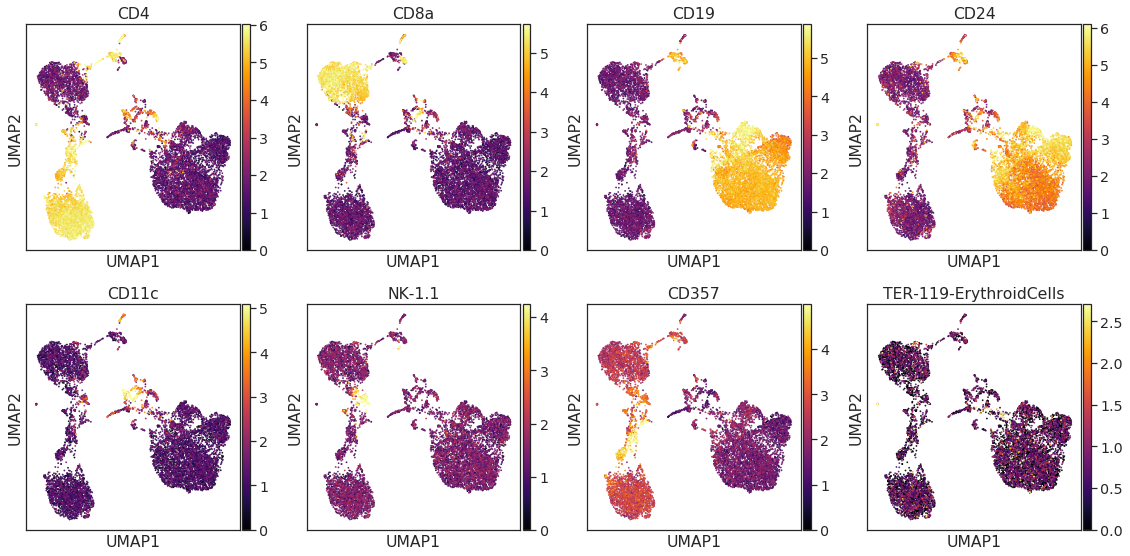

In [455]:
fig_path = "/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/"

fig, ax_arr = plt.subplots(2,4, figsize = (16, 8))
for i, protein in enumerate(["CD4", "CD8a", "CD19", "CD24", "CD11c", "NK-1.1" ,"CD357", "TER-119-ErythroidCells"]):    
    
    sc.pl.umap(
        protein_adata, 
        color=protein,
        alpha=0.9,
        #return_fig=True,
        frameon=True,
        #ncols=4,
        cmap="inferno",
        ax = ax_arr.flat[i],
        vmax = "p99.5",
        vmin = "p0.5",
        show = False,
        hspace=0.25,
        wspace=0.1 # .1
    )
plt.tight_layout()

fig.savefig(fig_path + "cell_type_markers.pdf", dpi = DPI)


In [ ]:
# parsed_pro_names = [s.split("_")[1].split("(")[0].split("-Er")[0] for s in dataset.protein_names]
# for i, p in enumerate(parsed_pro_names):
#     post_adatas[2].obs[p] = np.log1p(datasets[2].protein_expression[:, i])
    
# fig = sc.pl.umap(
#     post_adatas[2], 
#     color=["CD4", "CD8a", "CD19", "CD24", "CD11c", "NK-1.1" ,"CD357", "TER-119"],
#     alpha=0.9,
#     return_fig=True,
#     frameon=True,
#     ncols=4,
#     cmap="inferno",
#     hspace=0.25,
#     wspace=0.1
# )

### Plot background example histogram

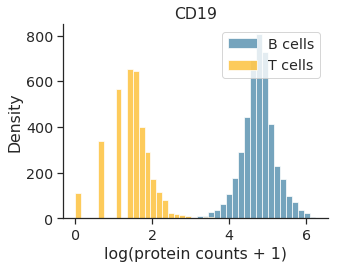

In [485]:
# Plot histogram of Raw CD19 expression in B cells vs T cells
# B cells
# T cells
# empty droplets

for RNA_name in ["Cd19"]:
    fig, ax = plt.subplots(figsize=(5, 4))
    #RNA_name = "Cd19"
    num_bins = 30
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]
#     ax.hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]]), bins = num_bins,
#               density = True, color = ".4" # colors[3]
#               )
    ax.hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.7,
            #density = True, 
            color = colors[0],
            label = "B cells"
              )
    ax.hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.7,
        #density = True, 
        color = colors[1],
        label = "T cells"
          )
    plt.legend(loc='upper right')

    ax.set(ylabel = "Density")
    ax.set(xlabel = "log(protein counts + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax.set_title(protein_title)
    sns.despine()
    plt.tight_layout()

    #fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/Denoised_%s_histogram.pdf" % protein_title, dpi=DPI, bbox_inches='tight')